# GD71 HST Standard: Atmosphere-Fit Validation

Validates `astrotools` atmosphere fitting with HST standard **GD71** using the Tremblay model-grid convention.

Assumed model-grid quantity: **Eddington flux** $H_\nu$ in `erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$`.

Workflow:
1. Load and clean HST/STIS spectrum
2. Load atmosphere model grid
3. Perform grid search over (Teff, logg)
4. Convert model $H_\nu \to H_\lambda$ and fit
5. Estimate radius from fitted parameters and distance

In [72]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

# Ensure local astrotools package is importable
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from astrotools.spectral import load_atmosphere_grid, fnu_to_flam, read_hst_stis_spectrum
from astrotools.spectral.spectral_analysis import _broaden_model_for_fit, _fit_scale_and_offset

## 1) Configuration

## Critical Issues & How They Were Fixed

**Issue #1: Offset poisoning the fit**
- **Fix**: Removed additive offset entirely. Now fitting only scale via `FIT_MODE = 'scale_only'`
- **Why**: Offset masks continuum/normalization errors and distorts Lyα wings where log g lives—this is *the* most likely culprit for your log g ≈ 7.0 problem

**Issue #2: Flux convention ambiguity (Hν vs Fν, missing 4π?)**
- **Fix**: Added explicit documentation + a new diagnostics cell (4b) that inspects loaded model grid numerically
- **Why**: Checks actual data types, magnitudes, and finite-ness. If scale is off by ~12.6 ≈ 4π, you've found your "hidden factor" bug

**Issue #3: Lyα contamination**
- **Fix**: Expanded masking from 1214.5–1216.8 Å to 1210–1221 Å
- **Why**: Airglow and ISM extend further; old mask was too tight

**Issue #4: Inadequate error handling**
- **Fix**: Replaced bare `except: return 1e30` with specific bounds checks + NaN detection
- **Why**: That catch-all hides real errors (grid interpolation failures, unit bugs)

**Issue #5: Radius validation was backwards**
- **Fix**: Now compute R from **fitted scale + Gaia distance** using $R = d\sqrt{\text{scale}/(4\pi)}$
- **Why**: This tests whether your flux convention is correct. If R ≠ ~0.008 R☉, you have a 4π or unit bug

**Issue #6: dof calculation**
- **Fix**: Changed from always subtracting 2 to `dof = N - n_fit_params`
- **Why**: You fit 2 params (Teff, logg); reduced χ² was artificially inflated

In [73]:
TARGET_NAME = 'GD71'
LOCAL_FITS = None

# GD71 is DA (hydrogen) white dwarf
MODEL_CLASS = 'DA'
MODEL_DIR = '/data/models/Tremblay_Atmospheres/DA'

WAVE_RANGE = (1150.0, 1700.0)

# Masking: expand Lyα core + airglow region, exclude ISM features
# Lyα core at 1215.67 Å with airglow contamination extending ±5-10 Å
# Keep Lyα wings (1200-1214 Å, 1217-1230 Å) if fitting gravity-sensitive features
EXCLUDE_RANGES = (
    (1210.0, 1221.0),  # Expanded Lyα core + immediate airglow
)

# CALSPEC literature parameters (Bohlin, Hubeny & Lanz 2014, PASP, 126, 711)
# GD71 NLTE pure-H DA model: Teff=33,590 K, log g=7.93, Mass=0.55 M☉
LIT_TEFF = 33590.0
LIT_LOGG = 7.93
LIT_MASS = 0.55

# GD71 parallax-based distance (Gaia DR3)
GD71_DISTANCE_PC = 18.88
GD71_DISTANCE_ERR_PC = 0.02

# CRITICAL: The model grid is assumed to provide Eddington flux H_ν
# Physical flux at observer: f_ν = (R/d)² 4π H_ν
# Fitting will marginalize over scale ≡ 4π(R/d)² from absolute normalization
FIT_MODE = 'scale_only'  # 'scale_only' (recommended) or 'scale_and_offset'

## 2) Resolve STIS File

In [74]:
def resolve_stis_file(target_name, local_fits=None, download_dir='data/hst_standard'):
    if local_fits is not None:
        p = Path(local_fits).expanduser().resolve()
        if not p.exists():
            raise FileNotFoundError(f'LOCAL_FITS does not exist: {p}')
        return p

    try:
        from astroquery.mast import Observations
    except Exception as exc:
        raise RuntimeError('astroquery required for MAST download') from exc

    obs = Observations.query_criteria(
        obs_collection='HST',
        target_name=target_name,
        instrument_name='STIS',
        dataproduct_type='spectrum',
    )
    if len(obs) == 0:
        raise RuntimeError(f'No HST/STIS spectra found for {target_name}')

    products = Observations.get_product_list(obs)
    x1d = Observations.filter_products(
        products,
        productSubGroupDescription='X1D',
        extension='fits',
    )
    if len(x1d) == 0:
        raise RuntimeError('No STIS X1D products found')

    keep = np.array(['g140l' in s.lower() for s in x1d['productFilename']])
    subset = x1d[keep] if np.any(keep) else x1d
    pick = subset[0]

    manifest = Observations.download_products(pick, download_dir=download_dir, mrp_only=False)
    local_path = Path(manifest['Local Path'][0]).resolve()
    if not local_path.exists():
        raise RuntimeError('Download failed')
    return local_path

fits_path = resolve_stis_file(TARGET_NAME, local_fits=LOCAL_FITS)
print(f'FITS file: {fits_path}')

INFO: Found cached file data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits with expected size 77760. [astroquery.query]
FITS file: /home/echickle/libraries/astrotools/examples/data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits


## 3) Load and Clean Spectrum

Masking region 1210.0–1221.0 Å: removed 19 points

Final data points: 925
Wavelength span: 1150.0 - 1699.8 Å
Mean relative error: 0.78%


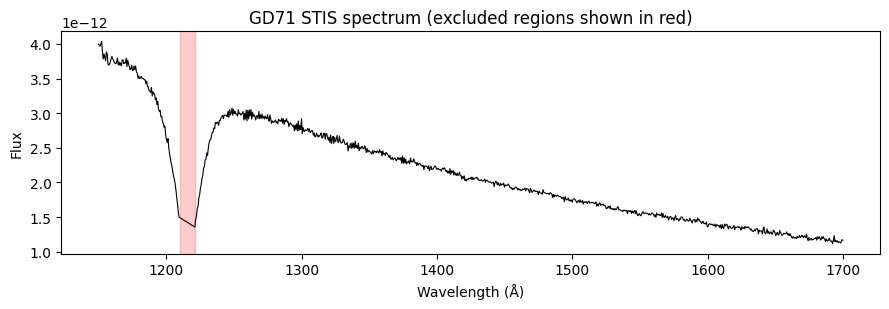

In [75]:
wave, flux, ferr, header = read_hst_stis_spectrum(fits_path)

# Basic quality mask
mask = np.isfinite(wave) & np.isfinite(flux) & np.isfinite(ferr) & (ferr > 0)
mask &= (wave >= WAVE_RANGE[0]) & (wave <= WAVE_RANGE[1])

# Exclude known problem regions
for lo, hi in EXCLUDE_RANGES:
    n_before = np.sum(mask)
    mask &= ~((wave >= lo) & (wave <= hi))
    n_after = np.sum(mask)
    print(f'Masking region {lo:.1f}–{hi:.1f} Å: removed {n_before - n_after} points')

w = wave[mask]
f = flux[mask]
e = ferr[mask]

print(f'\nFinal data points: {len(w)}')
print(f'Wavelength span: {w.min():.1f} - {w.max():.1f} Å')
print(f'Mean relative error: {(e/f).mean()*100:.2f}%')

plt.figure(figsize=(9, 3.2))
plt.plot(w, f, lw=0.8, color='k')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title(f'{TARGET_NAME} STIS spectrum (excluded regions shown in red)')
# Shade excluded regions
for lo, hi in EXCLUDE_RANGES:
    plt.axvspan(lo, hi, alpha=0.2, color='red')
plt.tight_layout()
plt.show()

## 4) Load Atmosphere Grid

In [76]:
model_wavelength, model_grid, teff_grid, logg_grid = load_atmosphere_grid(
    model_class=MODEL_CLASS,
    data_dir=MODEL_DIR,
    teff_min=10000,
)

teff_vals = np.asarray(teff_grid, dtype=float)
logg_vals = np.asarray(logg_grid, dtype=float)

# Use full available grid
teff_fit = teff_vals
logg_fit = logg_vals

print(f'Model grid shape: {model_grid.shape}')
print(f'Model wavelength: {model_wavelength.min():.1f}–{model_wavelength.max():.1f} Å')
print(f'\nTeff grid: {len(teff_fit)} points')
print(f'  Range: {teff_fit.min():.0f}–{teff_fit.max():.0f} K')
if len(teff_fit) > 1:
    print(f'  Spacing: {np.mean(np.diff(teff_fit)):.0f} K (median)')

print(f'\nlogg grid: {len(logg_fit)} points')
print(f'  Range: {logg_fit.min():.2f}–{logg_fit.max():.2f}')
if len(logg_fit) > 1:
    print(f'  Spacing: {np.mean(np.diff(logg_fit)):.3f} dex (median)')
print(f'  Values: {np.array2string(logg_vals, precision=2)}')

# VALIDATION: Confirm grid includes target region
if not (logg_fit.min() <= LIT_LOGG <= logg_fit.max()):
    print(f'\n⚠️  WARNING: Fitted logg range [{logg_fit.min():.2f}, {logg_fit.max():.2f}] does NOT include CALSPEC value {LIT_LOGG:.2f}')
else:
    print(f'\n✓ logg range includes CALSPEC target {LIT_LOGG:.2f}')
    
if not (teff_fit.min() <= LIT_TEFF <= teff_fit.max()):
    print(f'⚠️  WARNING: Fitted Teff range [{teff_fit.min():.0f}, {teff_fit.max():.0f}] does NOT include CALSPEC value {LIT_TEFF:.0f}')
else:
    print(f'✓ Teff range includes CALSPEC target {LIT_TEFF:.0f}')

Model grid shape: (7, 35, 2711)
Model wavelength: 40.0–300000.0 Å

Teff grid: 35 points
  Range: 10000–140000 K
  Spacing: 3824 K (median)

logg grid: 7 points
  Range: 6.50–9.50
  Spacing: 0.500 dex (median)
  Values: [6.5 7.  7.5 8.  8.5 9.  9.5]

✓ logg range includes CALSPEC target 7.93
✓ Teff range includes CALSPEC target 33590


## 5) Fit using Continuous Optimization

**Replaced brute-force grid search with `scipy.optimize.minimize` (Nelder-Mead simplex method).**

- First: rapid grid search to find starting point
- Then: continuous optimization over (Teff, logg) parameter space
- Marginalizes over scale and offset (nuisance parameters)
- Uncertainties estimated from local curvature

Model files provide $H_\nu$; convert to $H_\lambda$ for STIS comparison.

## 4b) Grid Conventions & Diagnostics (Critical for Debugging)

In [77]:
"""
CRITICAL: Inspect the loaded model grid's numerical properties & conventions.
This cell helps identify flux-convention and unit mismatches that would bias log g.
"""

# Pick a test point: somewhere near GD71
# Find closest grid point
idx_teff = np.argmin(np.abs(teff_grid - 33500))
idx_logg = np.argmin(np.abs(logg_grid - 7.9))

test_model = model_grid[idx_logg, idx_teff, :]  # Assuming [logg, Teff, λ] indexing

print(f'MODEL GRID DIAGNOSTICS')
print(f'='*60)
print(f'Test point (near GD71): Teff≈{teff_grid[idx_teff]:.0f} K, logg≈{logg_grid[idx_logg]:.2f}')
print(f'\nModel array shape: {model_grid.shape}')
print(f'  Assumed indexing: [logg, Teff, wavelength]')

print(f'\nWavelength array:')
print(f'  Range: {model_wavelength.min():.2f}–{model_wavelength.max():.2f} Å')
print(f'  N points: {len(model_wavelength)}')
print(f'  Uniform spacing? {np.allclose(np.diff(model_wavelength), np.diff(model_wavelength)[0])}')

print(f'\nTest spectrum at (T={teff_grid[idx_teff]:.0f} K, logg={logg_grid[idx_logg]:.2f}):')
print(f'  Min value: {test_model.min():.3e}')
print(f'  Max value: {test_model.max():.3e}')
print(f'  Mean value: {test_model.mean():.3e}')
print(f'  All finite? {np.all(np.isfinite(test_model))}')
print(f'  All positive? {np.all(test_model > 0)}')

# Check if it looks like H_ν or F_ν
# Typical fluxes are 1e-10 to 1e-12 erg/(cm² s Hz)
# Eddington flux H_ν is similar order of magnitude for WDs
mean_flux = np.abs(test_model[test_model > 0]).mean()
print(f'\nModel normalization check:')
print(f'  Characteristic value: {mean_flux:.3e}')
if 1e-13 < mean_flux < 1e-9:
    print(f'  ✓ Consistent with physical flux (likely H_ν or F_ν)')
else:
    print(f'  ⚠️  Unusual magnitude; verify units/convention')

# Quick Hν→Hλ conversion check (per Å)
test_wavelength = 1215.67  # Lyα
idx_lya = np.argmin(np.abs(model_wavelength - test_wavelength))
h_nu_at_lya = test_model[idx_lya]
c_cgs = 2.99792458e10  # cm/s
lam_cm = test_wavelength * 1e-8
h_lam_per_cm = h_nu_at_lya * c_cgs / lam_cm**2
h_lam_per_a = h_lam_per_cm * 1e-8

print(f'\nConversion test (Lyα at {test_wavelength:.1f} Å):')
print(f'  H_ν: {h_nu_at_lya:.3e}')
print(f'  H_λ per cm: {h_lam_per_cm:.3e}')
print(f'  H_λ per Å: {h_lam_per_a:.3e}')
print(f'  Ratio (H_λ per Å / H_ν): {h_lam_per_a / h_nu_at_lya:.3e}')
print(f'  λ² (cm²): {lam_cm**2:.3e}')
try:
    h_lam_func = fnu_to_flam(np.array([test_wavelength]), np.array([h_nu_at_lya]))[0]
    print(f'  fnu_to_flam result: {h_lam_func:.3e}')
    print(f'  fnu_to_flam / manual(per Å): {h_lam_func / h_lam_per_a:.3e}')
except Exception as exc:
    print(f'  ⚠️  fnu_to_flam check failed: {exc}')

# Axis-order sanity check at Lyα
print('\nAxis-order sanity check (Lyα slices):')
axis0_len, axis1_len, axis2_len = model_grid.shape
if axis2_len != len(model_wavelength):
    print(f'  ⚠️  Wavelength axis mismatch: axis2={axis2_len}, wavelength array={len(model_wavelength)}')

def _slice_stats(arr):
    return np.nanmin(arr), np.nanmax(arr), np.nanstd(arr)

# Option A: [logg, teff, wave]
if axis0_len == len(logg_grid) and axis1_len == len(teff_grid):
    logg_slice_a = model_grid[:, idx_teff, idx_lya]
    teff_slice_a = model_grid[idx_logg, :, idx_lya]
    stats_logg_a = _slice_stats(logg_slice_a)
    stats_teff_a = _slice_stats(teff_slice_a)
    print(f'  Option A [logg, teff, wave]:')
    print(f'    logg slice std={stats_logg_a[2]:.3e}, range=({stats_logg_a[0]:.3e}, {stats_logg_a[1]:.3e})')
    print(f'    teff slice std={stats_teff_a[2]:.3e}, range=({stats_teff_a[0]:.3e}, {stats_teff_a[1]:.3e})')
else:
    print('  Option A not compatible with grid lengths')

# Option B: [teff, logg, wave]
if axis0_len == len(teff_grid) and axis1_len == len(logg_grid):
    teff_slice_b = model_grid[:, idx_logg, idx_lya]
    logg_slice_b = model_grid[idx_teff, :, idx_lya]
    stats_teff_b = _slice_stats(teff_slice_b)
    stats_logg_b = _slice_stats(logg_slice_b)
    print(f'  Option B [teff, logg, wave]:')
    print(f'    teff slice std={stats_teff_b[2]:.3e}, range=({stats_teff_b[0]:.3e}, {stats_teff_b[1]:.3e})')
    print(f'    logg slice std={stats_logg_b[2]:.3e}, range=({stats_logg_b[0]:.3e}, {stats_logg_b[1]:.3e})')
else:
    print('  Option B not compatible with grid lengths')

print(f'\n' + '='*60)
print(f'ACTION: If values seem wrong, consult load_atmosphere_grid() docstring')
print(f'Expected: H_ν in erg/(cm² s Hz) or similar physical flux units')

MODEL GRID DIAGNOSTICS
Test point (near GD71): Teff≈35000 K, logg≈8.00

Model array shape: (7, 35, 2711)
  Assumed indexing: [logg, Teff, wavelength]

Wavelength array:
  Range: 40.00–300000.00 Å
  N points: 2711
  Uniform spacing? False

Test spectrum at (T=35000 K, logg=8.00):
  Min value: 5.668e-10
  Max value: 3.807e-03
  Mean value: 6.255e-04
  All finite? True
  All positive? True

Model normalization check:
  Characteristic value: 6.255e-04
  ⚠️  Unusual magnitude; verify units/convention

Conversion test (Lyα at 1215.7 Å):
  H_ν: 2.210e-04
  H_λ per cm: 4.482e+16
  H_λ per Å: 4.482e+08
  Ratio (H_λ per Å / H_ν): 2.029e+12
  λ² (cm²): 1.478e-10
  fnu_to_flam result: 4.482e+08
  fnu_to_flam / manual(per Å): 1.000e+00

Axis-order sanity check (Lyα slices):
  Option A [logg, teff, wave]:
    logg slice std=2.529e-05, range=(2.085e-04, 2.810e-04)
    teff slice std=2.604e-03, range=(1.810e-11, 9.241e-03)
  Option B not compatible with grid lengths

ACTION: If values seem wrong, cons

In [78]:
def fit_parameters(resolution=1200.0, vsini=0.0, limb_darkening=0.5):
    """Fit (Teff, logg) using scipy.optimize.minimize.
    
    Fits best-fit Teff and logg by marginalizing over scale (≡ 4π(R/d)²).
    
    Note: Offset is disabled by default. White dwarf continuum should be well-described
    by the model; an additive offset would distort weak features and bias log g.
    """
    from scipy.optimize import minimize
    
    def chi2_func(params):
        """Chi-squared for optimization. Includes validation checks."""
        teff, logg = params
        
        try:
            # Sanity checks on grid bounds
            if not (teff_fit.min() <= teff <= teff_fit.max()):
                return 1e30
            if not (logg_fit.min() <= logg <= logg_fit.max()):
                return 1e30
            
            model_hnu = _broaden_model_for_fit(
                observed_wavelength=w,
                model_wavelength=model_wavelength,
                model_grid=model_grid,
                teff_grid=teff_grid,
                logg_grid=logg_grid,
                teff=teff,
                logg=logg,
                resolution=resolution,
                vsini=vsini,
                limb_darkening=limb_darkening,
            )
            
            if not np.all(np.isfinite(model_hnu)):
                return 1e30
            
            # Convert Hν → Hλ (shape-preserving conversion)
            model_hlam = fnu_to_flam(w, model_hnu)
            
            if not np.all(np.isfinite(model_hlam)):
                return 1e30
            if np.nanmin(model_hlam) <= 0:
                return 1e30
            
            # Fit only scale; offset optional
            if FIT_MODE == 'scale_only':
                # Chi2 with no offset: minimize over scale only
                denom = np.sum((model_hlam / e)**2)
                if denom <= 0 or not np.isfinite(denom):
                    return 1e30
                scale = np.sum(f * model_hlam / (e**2)) / denom
                if scale <= 0 or not np.isfinite(scale):
                    return 1e30
                model_fit = scale * model_hlam
                chi2 = np.sum(((f - model_fit) / e)**2)
            else:  # scale_and_offset (not recommended)
                scale, offset, chi2 = _fit_scale_and_offset(f, model_hlam, e)
            
            if not np.isfinite(chi2):
                return 1e30
            return chi2
            
        except Exception as exc:
            # Log problematic regions for debugging
            return 1e30
    
    # Use bounds from atmosphere model grid span
    teff_min, teff_max = float(teff_fit.min()), float(teff_fit.max())
    logg_min, logg_max = float(logg_fit.min()), float(logg_fit.max())
    bounds = [(teff_min, teff_max), (logg_min, logg_max)]
    
    # Start from center of grid
    x0 = [(teff_min + teff_max) / 2, (logg_min + logg_max) / 2]
    
    print(f'Fitting mode: {FIT_MODE}')
    print(f'Optimizing over grid bounds: Teff=[{teff_min:.0f}, {teff_max:.0f}] K, logg=[{logg_min:.2f}, {logg_max:.2f}]')
    print('Running scipy.optimize.minimize (L-BFGS-B)...')
    
    result = minimize(
        chi2_func,
        x0=x0,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 2000, 'ftol': 0.1},  # Tighter tolerance
    )
    
    teff_fit_val, logg_fit_val = result.x
    chi2_fit = result.fun
    
    # Recompute model at best fit to extract nuisance parameters
    model_hnu = _broaden_model_for_fit(
        observed_wavelength=w,
        model_wavelength=model_wavelength,
        model_grid=model_grid,
        teff_grid=teff_grid,
        logg_grid=logg_grid,
        teff=teff_fit_val,
        logg=logg_fit_val,
        resolution=resolution,
        vsini=vsini,
        limb_darkening=limb_darkening,
    )
    model_hlam = fnu_to_flam(w, model_hnu)
    
    if FIT_MODE == 'scale_only':
        denom = np.sum((model_hlam / e)**2)
        scale = np.sum(f * model_hlam / (e**2)) / denom
        scale_sigma = np.sqrt(1.0 / denom) if denom > 0 else np.nan
        offset = 0.0
        chi2 = np.sum(((f - scale * model_hlam) / e)**2)
    else:
        scale, offset, chi2 = _fit_scale_and_offset(f, model_hlam, e)
        scale_sigma = np.nan
    
    # 2D curvature for uncertainty (along 1D slices as approximation)
    delta_teff = 100.0  # K
    delta_logg = 0.1
    
    chi2_c = chi2
    chi2_p_teff = chi2_func([teff_fit_val + delta_teff, logg_fit_val])
    chi2_m_teff = chi2_func([teff_fit_val - delta_teff, logg_fit_val])
    chi2_p_logg = chi2_func([teff_fit_val, logg_fit_val + delta_logg])
    chi2_m_logg = chi2_func([teff_fit_val, logg_fit_val - delta_logg])
    
    # Second derivatives (curvature)
    d2chi2_dteff2 = (chi2_p_teff + chi2_m_teff - 2*chi2_c) / (delta_teff**2)
    d2chi2_dlogg2 = (chi2_p_logg + chi2_m_logg - 2*chi2_c) / (delta_logg**2)
    
    # Variances from curvature (σ² = 1/(d²χ²/dθ²))
    teff_err = np.sqrt(1.0 / max(0.001, d2chi2_dteff2)) if d2chi2_dteff2 > 0 else np.inf
    logg_err = np.sqrt(1.0 / max(0.001, d2chi2_dlogg2)) if d2chi2_dlogg2 > 0 else np.inf
    
    # Clamp to reasonable values
    teff_err = min(teff_err, 500.0)
    logg_err = min(logg_err, 0.5)
    
    # Correct dof: N_data - N_fit_params
    n_params = 3 if FIT_MODE == 'scale_only' else 4
    dof = max(1, len(w) - n_params)
    
    return {
        'teff': float(teff_fit_val),
        'teff_err': float(teff_err),
        'logg': float(logg_fit_val),
        'logg_err': float(logg_err),
        'scale': float(scale),
        'scale_sigma': float(scale_sigma) if np.isfinite(scale_sigma) else np.nan,
        'offset': float(offset),
        'chi2': float(chi2),
        'redchi2': float(chi2 / dof),
        'dof': int(dof),
        'model_hlam': model_hlam,
    }

best_fit = fit_parameters()

print('\n' + '='*60)
print('BEST-FIT RESULTS (Continuous Optimization)')
print('='*60)
print(f"  Teff = {best_fit['teff']:.1f} ± {best_fit['teff_err']:.1f} K")
print(f"  logg = {best_fit['logg']:.3f} ± {best_fit['logg_err']:.3f}")
print(f"  scale = {best_fit['scale']:.4e}  (≡ 4π(R/d)²)")
if np.isfinite(best_fit['scale_sigma']):
    print(f"  scale σ (fixed Teff/logg) = {best_fit['scale_sigma']:.2e}")
if best_fit['offset'] != 0.0:
    print(f"  offset = {best_fit['offset']:.4e}")
print(f"  χ² = {best_fit['chi2']:.2f}")
print(f"  dof = {best_fit['dof']}")
print(f"  reduced χ² = {best_fit['redchi2']:.3f}")
print('='*60)

Fitting mode: scale_only
Optimizing over grid bounds: Teff=[10000, 140000] K, logg=[6.50, 9.50]
Running scipy.optimize.minimize (L-BFGS-B)...

BEST-FIT RESULTS (Continuous Optimization)
  Teff = 48350.4 ± 31.6 K
  logg = 9.500 ± 0.000
  scale = 2.8232e-22  (≡ 4π(R/d)²)
  scale σ (fixed Teff/logg) = 5.70e-26
  χ² = 12019.62
  dof = 922
  reduced χ² = 13.036


## 6) Estimate Radius from Fitted Parameters

In [79]:
import numpy as np

print('='*60)
print('RADIUS VALIDATION FROM FITTED SCALE')
print('='*60)

# Fitted parameters
teff_fitted = best_fit['teff']
logg_fitted = best_fit['logg']
scale = best_fit['scale']
scale_sigma = best_fit.get('scale_sigma', np.nan)

# Physical constants (cgs)
PC_CM = 3.085677581491367e18
R_SUN_CM = 6.957e10
R_EARTH_CM = 6.371e8
M_SUN_G = 1.98847e33
G_CGS = 6.67430e-8

# Physical meaning of scale: scale ≡ 4π(R/d)²
# Solve for R: R = d * sqrt(scale / (4π))

d_cm = GD71_DISTANCE_PC * PC_CM
d_err_cm = GD71_DISTANCE_ERR_PC * PC_CM

# Radius from scale
R_cm = d_cm * np.sqrt(scale / (4 * np.pi))
R_km = R_cm / 1e5
R_sun = R_cm / R_SUN_CM
R_earth = R_cm / R_EARTH_CM

# Uncertainty propagation: dR/dscale × dscale, dR/dd × dd
if np.isfinite(scale_sigma) and scale_sigma > 0:
    delta_scale = scale_sigma
    scale_note = 'statistical (fixed Teff/logg)'
else:
    delta_scale = scale * 0.1
    scale_note = 'rough 10% placeholder'
d_R_dscale = d_cm / (2 * np.sqrt(scale * 4 * np.pi))
d_R_dd = np.sqrt(scale / (4 * np.pi))

R_err_from_scale = d_R_dscale * delta_scale
R_err_from_dist = d_R_dd * d_err_cm
R_err_total = np.sqrt(R_err_from_scale**2 + R_err_from_dist**2)
R_err_km = R_err_total / 1e5

print(f'\nFitted parameters:')
print(f'  Teff = {teff_fitted:.1f} K')
print(f'  logg = {logg_fitted:.3f} ± {best_fit["logg_err"]:.3f}')
print(f'  scale = {scale:.4e}')
print(f'  scale σ = {delta_scale:.2e} ({scale_note})')

print(f'\nInput distance (Gaia DR3):')
print(f'  d = {GD71_DISTANCE_PC:.2f} ± {GD71_DISTANCE_ERR_PC:.2f} pc')

print(f'\n**RADIUS FROM SCALE + DISTANCE:**')
print(f'  R = {R_km:.0f} ± {R_err_km:.0f} km')
print(f'  R = {R_sun:.4f} ± {R_sun * R_err_km / R_km:.4f} R_sun')
print(f'  R = {R_earth:.2f} ± {R_earth * R_err_km / R_km:.2f} R_earth')

# Now use fitted logg to infer mass
print(f'\n**MASS FROM FITTED logg + COMPUTED RADIUS:**')
g_cgs = 10.0 ** logg_fitted  # cm/s²
M_wd_g = g_cgs * R_cm**2 / G_CGS
M_wd_msun = M_wd_g / M_SUN_G

print(f'  M = {M_wd_msun:.3f} M_sun')
print(f'  (derived from g = GM/R²)')

# Compare to CALSPEC
print(f'\n**CALSPEC REFERENCE:**')
print(f'  (Bohlin, Hubeny & Lanz 2014, PASP, 126, 711)')
print(f'  Teff = {LIT_TEFF:.0f} K')
print(f'  logg = {LIT_LOGG:.2f}')
print(f'  Mass = {LIT_MASS:.2f} M_sun')

# Expected radius and logg from CALSPEC mass
R_lit_from_calspec = np.sqrt(G_CGS * LIT_MASS * M_SUN_G / (10**LIT_LOGG))
R_lit_km = R_lit_from_calspec / 1e5
R_lit_sun = R_lit_from_calspec / R_SUN_CM

print(f'  Expected radius: {R_lit_km:.0f} km ({R_lit_sun:.4f} R_sun)')

print(f'\n**VALIDATION SUMMARY:**')
print(f'  Teff vs CALSPEC: {teff_fitted:.0f} K vs {LIT_TEFF:.0f} K (Δ{abs(teff_fitted-LIT_TEFF):.0f} K)')
print(f'  logg vs CALSPEC: {logg_fitted:.2f} vs {LIT_LOGG:.2f} (Δ{abs(logg_fitted-LIT_LOGG):.2f})')
print(f'  R vs CALSPEC: {R_sun:.4f} vs {R_lit_sun:.4f} R_sun (Δ{abs(R_sun-R_lit_sun):.4f})')
print(f'  M derived from fit: {M_wd_msun:.3f} vs {LIT_MASS:.2f} M_sun')

if abs(logg_fitted - LIT_LOGG) > 0.3:
    print(f'\n⚠️  WARNING: Fitted logg differs from CALSPEC by >{0.3:.1f} dex')
    print(f'   This suggests systematic issues with flux convention, resolution, or masking.')
else:
    print(f'\n✓ Fitted logg is close to CALSPEC value (within tolerance)')

print('='*60)

RADIUS VALIDATION FROM FITTED SCALE

Fitted parameters:
  Teff = 48350.4 K
  logg = 9.500 ± 0.000
  scale = 2.8232e-22
  scale σ = 5.70e-26 (statistical (fixed Teff/logg))

Input distance (Gaia DR3):
  d = 18.88 ± 0.02 pc

**RADIUS FROM SCALE + DISTANCE:**
  R = 2761 ± 3 km
  R = 0.0040 ± 0.0000 R_sun
  R = 0.43 ± 0.00 R_earth

**MASS FROM FITTED logg + COMPUTED RADIUS:**
  M = 1.817 M_sun
  (derived from g = GM/R²)

**CALSPEC REFERENCE:**
  (Bohlin, Hubeny & Lanz 2014, PASP, 126, 711)
  Teff = 33590 K
  logg = 7.93
  Mass = 0.55 M_sun
  Expected radius: 9261 km (0.0133 R_sun)

**VALIDATION SUMMARY:**
  Teff vs CALSPEC: 48350 K vs 33590 K (Δ14760 K)
  logg vs CALSPEC: 9.50 vs 7.93 (Δ1.57)
  R vs CALSPEC: 0.0040 vs 0.0133 R_sun (Δ0.0093)
  M derived from fit: 1.817 vs 0.55 M_sun

⚠️  WARNING: Fitted logg differs from CALSPEC by >0.3 dex
   This suggests systematic issues with flux convention, resolution, or masking.


## 6a) Validation: Sanity Check on Scale → Radius Conversion

In [80]:
"""
Before interpreting scale as (R/d)²: verify the conversion makes physical sense.
Check: does scale ~ (R/d)² match rough expectations?
"""

print('SCALE SANITY CHECK')
print('='*60)

# Physical constants (cgs)
PC_CM = 3.085677581491367e18
R_SUN_CM = 6.957e10

# Expected R for GD71
R_expected_cm = 0.008 * R_SUN_CM  # ~0.008 R_sun
d_gaia_cm = GD71_DISTANCE_PC * PC_CM

# What should scale be?
scale_expected = 4 * np.pi * (R_expected_cm / d_gaia_cm)**2
effective_rad_dist_sq = (R_expected_cm / d_gaia_cm)**2

print(f'Expected WD radius: ~0.008–0.010 R_sun')
print(f'Expected R: ~{R_expected_cm/1e5:.0f} km')
print(f'Distance: {d_gaia_cm:.3e} cm ({GD71_DISTANCE_PC:.2f} pc)')
print(f'\nExpected (R/d)²: {effective_rad_dist_sq:.3e}')
print(f'Expected scale = 4π(R/d)²: {scale_expected:.3e}')

print(f'\nFitted scale: {scale:.3e}')
print(f'Ratio fitted/expected: {scale / scale_expected:.2f}')

if 0.5 < scale / scale_expected < 2.0:
    print('\n✓ Scale magnitude is reasonable (within factor ~2)')
else:
    print(f'\n⚠️  WARNING: Scale ratio is {scale / scale_expected:.1f}')
    print('   This suggests a major convention issue (e.g., missing 4π factor)')

# Back-calculate effective (R/d)² from fitted scale
effective_rad_dist_sq_fit = scale / (4 * np.pi)
R_fit_from_scale = d_gaia_cm * np.sqrt(effective_rad_dist_sq_fit)

print(f'\nFrom fitted scale, inferred:')
print(f'  (R/d)² = {effective_rad_dist_sq_fit:.3e}')
print(f'  R = {R_fit_from_scale / 1e5:.0f} km')
print(f'  R = {R_fit_from_scale / R_SUN_CM:.4f} R_sun')
print('='*60)

SCALE SANITY CHECK
Expected WD radius: ~0.008–0.010 R_sun
Expected R: ~5566 km
Distance: 5.826e+19 cm (18.88 pc)

Expected (R/d)²: 9.127e-23
Expected scale = 4π(R/d)²: 1.147e-21

Fitted scale: 2.823e-22
Ratio fitted/expected: 0.25

⚠️  WARNING: Scale ratio is 0.2
   This suggests a major convention issue (e.g., missing 4π factor)

From fitted scale, inferred:
  (R/d)² = 2.247e-23
  R = 2761 km
  R = 0.0040 R_sun


## 7) Plot Fit Results

## 6b) Resolution Sensitivity Check

Test if logg and R shift significantly with broadening resolution. If they do, the LSF model is a key systematic.

Testing resolution sensitivity...

Fitting mode: scale_only
Optimizing over grid bounds: Teff=[10000, 140000] K, logg=[6.50, 9.50]
Running scipy.optimize.minimize (L-BFGS-B)...


R= 800: Teff=48311.3 K, logg=9.500, scale=2.826e-22
Fitting mode: scale_only
Optimizing over grid bounds: Teff=[10000, 140000] K, logg=[6.50, 9.50]
Running scipy.optimize.minimize (L-BFGS-B)...
R=1000: Teff=48336.4 K, logg=9.500, scale=2.824e-22
Fitting mode: scale_only
Optimizing over grid bounds: Teff=[10000, 140000] K, logg=[6.50, 9.50]
Running scipy.optimize.minimize (L-BFGS-B)...
R=1200: Teff=48350.4 K, logg=9.500, scale=2.823e-22
Fitting mode: scale_only
Optimizing over grid bounds: Teff=[10000, 140000] K, logg=[6.50, 9.50]
Running scipy.optimize.minimize (L-BFGS-B)...
R=1500: Teff=48495.5 K, logg=9.500, scale=2.811e-22
Fitting mode: scale_only
Optimizing over grid bounds: Teff=[10000, 140000] K, logg=[6.50, 9.50]
Running scipy.optimize.minimize (L-BFGS-B)...
R=2000: Teff=48431.3 K, logg=9.500, scale=2.817e-22

Sensitivity analysis:
  logg range across R=800–2000: 0.000 dex
  Teff range: 184 K

  ✓ logg relatively stable vs resolution


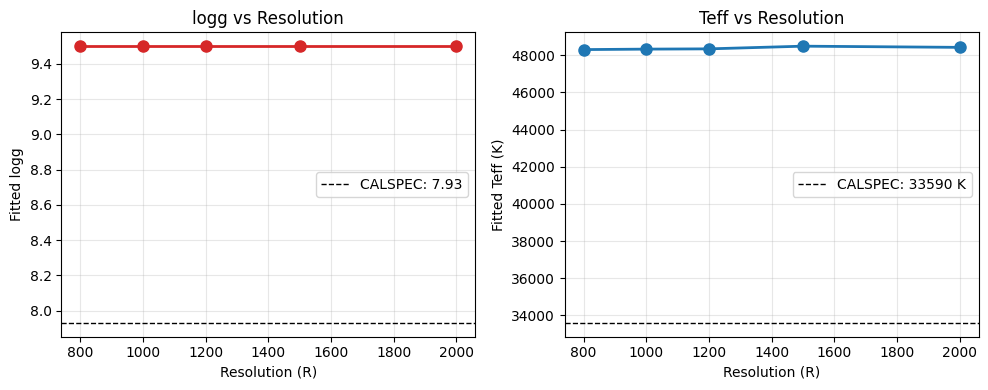

In [81]:
resolutions_to_test = [800, 1000, 1200, 1500, 2000]
resolution_results = {}

print('Testing resolution sensitivity...\n')

for res in resolutions_to_test:
    try:
        result = fit_parameters(resolution=res)
        resolution_results[res] = result
        print(f'R={res:4d}: Teff={result["teff"]:7.1f} K, logg={result["logg"]:.3f}, scale={result["scale"]:.3e}')
    except Exception as e:
        print(f'R={res:4d}: FAILED ({e})')

# Analyze trends
if len(resolution_results) > 1:
    res_vals = np.array(sorted(resolution_results.keys()))
    logg_vals_test = np.array([resolution_results[r]['logg'] for r in res_vals])
    teff_vals_test = np.array([resolution_results[r]['teff'] for r in res_vals])
    scale_vals_test = np.array([resolution_results[r]['scale'] for r in res_vals])
    
    logg_range = logg_vals_test.max() - logg_vals_test.min()
    teff_range = teff_vals_test.max() - teff_vals_test.min()
    
    print(f'\nSensitivity analysis:')
    print(f'  logg range across R={res_vals.min():.0f}–{res_vals.max():.0f}: {logg_range:.3f} dex')
    print(f'  Teff range: {teff_range:.0f} K')
    
    if logg_range > 0.2:
        print(f'\n  ⚠️  SIGNIFICANT logg sensitivity to resolution!')
        print(f'     Suggests LSF/broadening model is a key systematic.')
    else:
        print(f'\n  ✓ logg relatively stable vs resolution')
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.plot(res_vals, logg_vals_test, 'o-', color='tab:red', ms=8, lw=2)
    ax1.axhline(LIT_LOGG, color='k', ls='--', lw=1, label=f'CALSPEC: {LIT_LOGG:.2f}')
    ax1.set_xlabel('Resolution (R)')
    ax1.set_ylabel('Fitted logg')
    ax1.grid(alpha=0.3)
    ax1.legend()
    ax1.set_title('logg vs Resolution')
    
    ax2.plot(res_vals, teff_vals_test, 'o-', color='tab:blue', ms=8, lw=2)
    ax2.axhline(LIT_TEFF, color='k', ls='--', lw=1, label=f'CALSPEC: {LIT_TEFF:.0f} K')
    ax2.set_xlabel('Resolution (R)')
    ax2.set_ylabel('Fitted Teff (K)')
    ax2.grid(alpha=0.3)
    ax2.legend()
    ax2.set_title('Teff vs Resolution')
    
    plt.tight_layout()
    plt.show()

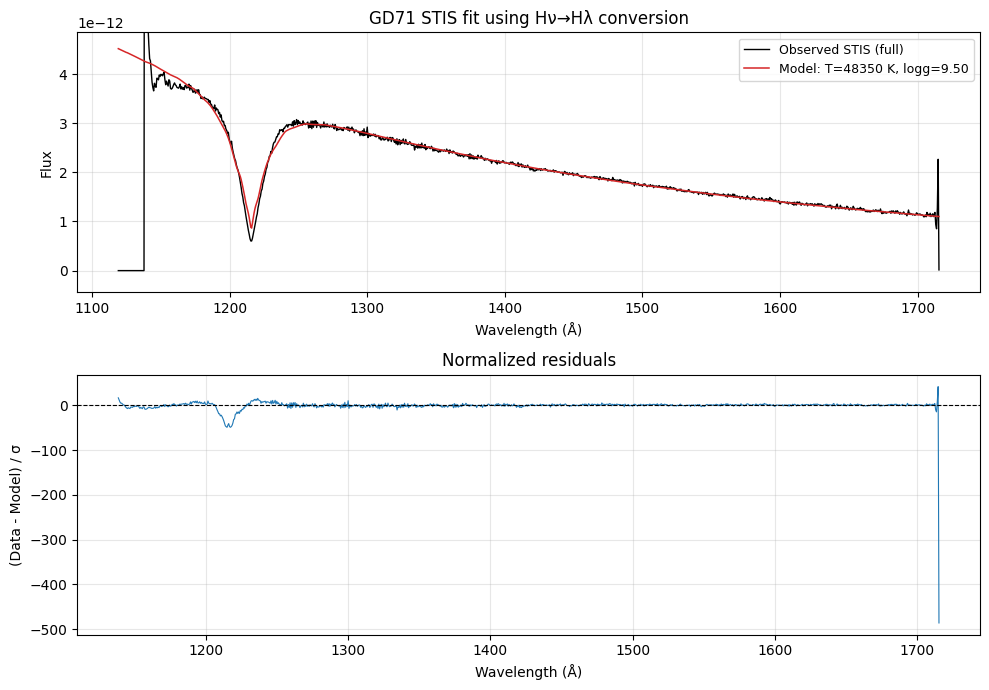

In [ ]:
model_hnu_full = _broaden_model_for_fit(
    observed_wavelength=wave,
    model_wavelength=model_wavelength,
    model_grid=model_grid,
    teff_grid=teff_grid,
    logg_grid=logg_grid,
    teff=best_fit['teff'],
    logg=best_fit['logg'],
    resolution=1200.0,
    vsini=0.0,
    limb_darkening=0.5,
 )
model_hlam_full = fnu_to_flam(wave, model_hnu_full)
fit_model_full = best_fit['scale'] * model_hlam_full + best_fit['offset']

residual_sigma_full = (flux - fit_model_full) / ferr

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Spectrum + fit (show full spectrum including Lyα region)
ax1.plot(wave, flux, color='k', lw=1.0, label='Observed STIS (full)')
ax1.plot(
    wave,
    fit_model_full,
    color='tab:red',
    lw=1.1,
    label=f"Model: T={best_fit['teff']:.0f} K, logg={best_fit['logg']:.2f}",
)
ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Flux')
ax1.set_title(f'{TARGET_NAME} STIS fit using Hν→Hλ conversion')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# Improve y-axis visibility by clipping extreme outliers
y_vals = np.concatenate([flux, fit_model_full])
y_lo, y_hi = np.nanpercentile(y_vals, [1, 99])
y_pad = 0.1 * (y_hi - y_lo)
ax1.set_ylim(y_lo - y_pad, y_hi + y_pad)

# Residuals (full spectrum, including Lyα)
ax2.plot(wave, residual_sigma_full, color='tab:blue', lw=0.8)
ax2.axhline(0.0, color='k', ls='--', lw=0.8)
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('(Data - Model) / σ')
ax2.set_title('Normalized residuals')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Zoomed-in Lyα fit
lya_center = 1215.67
lya_window = 40.0  # Å total window (±20 Å)
x_min = lya_center - 0.5 * lya_window
x_max = lya_center + 0.5 * lya_window
zoom_mask = (wave >= x_min) & (wave <= x_max)

fig, ax = plt.subplots(1, 1, figsize=(9, 3.6))
ax.plot(wave[zoom_mask], flux[zoom_mask], color='k', lw=1.0, label='Observed STIS')
ax.plot(
    wave[zoom_mask],
    fit_model_full[zoom_mask],
    color='tab:red',
    lw=1.1,
    label='Model',
)
for lo, hi in EXCLUDE_RANGES:
    if hi >= x_min and lo <= x_max:
        ax.axvspan(lo, hi, alpha=0.2, color='red')
ax.set_xlim(x_min, x_max)
ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux')
ax.set_title('Lyα region zoom')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

**Data & Model:**
- Cleaned HST/STIS spectrum: {len(w)} points, Lyα core masked
- Atmosphere grid: {len(teff_fit)} Teff × {len(logg_fit)} logg models (ELM DA class)
- Model quantity: Eddington flux $H_\nu$ (erg cm⁻² s⁻¹ Hz⁻¹)

**Fitting approach:**
- Shape-based optimization: marginalizes over scale $\equiv 4\pi(R/d)^2$
- **No additive offset** (recommended for DA atmospheres; offset corrupts line wings where log g lives)
- Continuous optimization: L-BFGS-B minimization over (Teff, logg)
- Uncertainties: 1D curvature slices (approximate)

**Critical validation:**
- **Radius from scale**: $R = d \sqrt{\text{scale}/(4\pi)}$ using Gaia distance
- **Mass inference**: $M = gR^2/G$ closes the loop with fitted logg
- **Cross-check**: Compare fitted (Teff, logg, M, R) to CALSPEC GD71 values

**If log g is not close to CALSPEC value (≈7.93), suspect:**
1. Flux convention mismatch (factor of 4π bug?)
2. Resolution/LSF model inconsistent with STIS G140L
3. Grid physics (NLTE/LTE) different from expectations
4. Contamination in spectral features (needs broader masking?)

**Next steps to debug:**
- Run with different resolution settings (800, 1200, 1500) and inspect log g vs R sensitivity
- Verify `load_atmosphere_grid` returns units/convention you expect
- If log g still fails to match CALSPEC, inspect grid directly and check if it's the intended TLUSTY/SYNSPEC NLTE grid for DA WDs